# Invariant Coordinate Selection (ICS) Python implementation

ICS is implemented in the package `ISpyLab`.

This tutorial presents the main functionalities of the package. If you need more details, check out the [documentation](https://icspylab.readthedocs.io/en/latest/index.html)!

## Installation

In [2]:
!python --version

Python 3.11.12


In [3]:
pip install numpy pandas scipy scikit-learn seaborn matplotlib icspylab

## Example 1: Basic ICS implementation

In [5]:
  import pandas as pd
  from icspylab import ICS, cov, covW, cov4
  from sklearn.datasets import load_iris

  # Load dataset
  iris = load_iris()
  X = pd.DataFrame(iris.data, columns=iris.feature_names)

  # Instantiate ICS object
  # ics = ICS() # default parameters
  ics = ICS(S1=cov, S2=covW, algorithm='standard', S2_args={'alpha': 1, 'cf': 2})

  # Fit and transform the ICS model (equivalent of the function ICS-S3() from the R package ICS)
  ics.fit_transform(X)

  # Printing a summary
  ics.describe()


ICS based on two scatter matrices
S1: cov
S1_args: {}
S2: covW
S2_args: {'alpha': 1, 'cf': 2}

Information on the algorithm:
algorithm: standard
center: False
fix_signs: scores

The generalized kurtosis measures of the components are:
IC_1: 14.4888
IC_2: 12.3233
IC_3: 11.1507
IC_4: 8.8856

The coefficient matrix of the linear transformation is:
     sepal length (cm) sepal width (cm) petal length (cm) petal width (cm)
IC_1       -0.52335      1.99326      2.37305     -4.43078
IC_2        0.83296      1.32750     -1.26665      2.78998
IC_3        3.05683     -2.22695     -1.63543      0.36544
IC_4        0.05244      0.60315     -0.34826     -0.37984


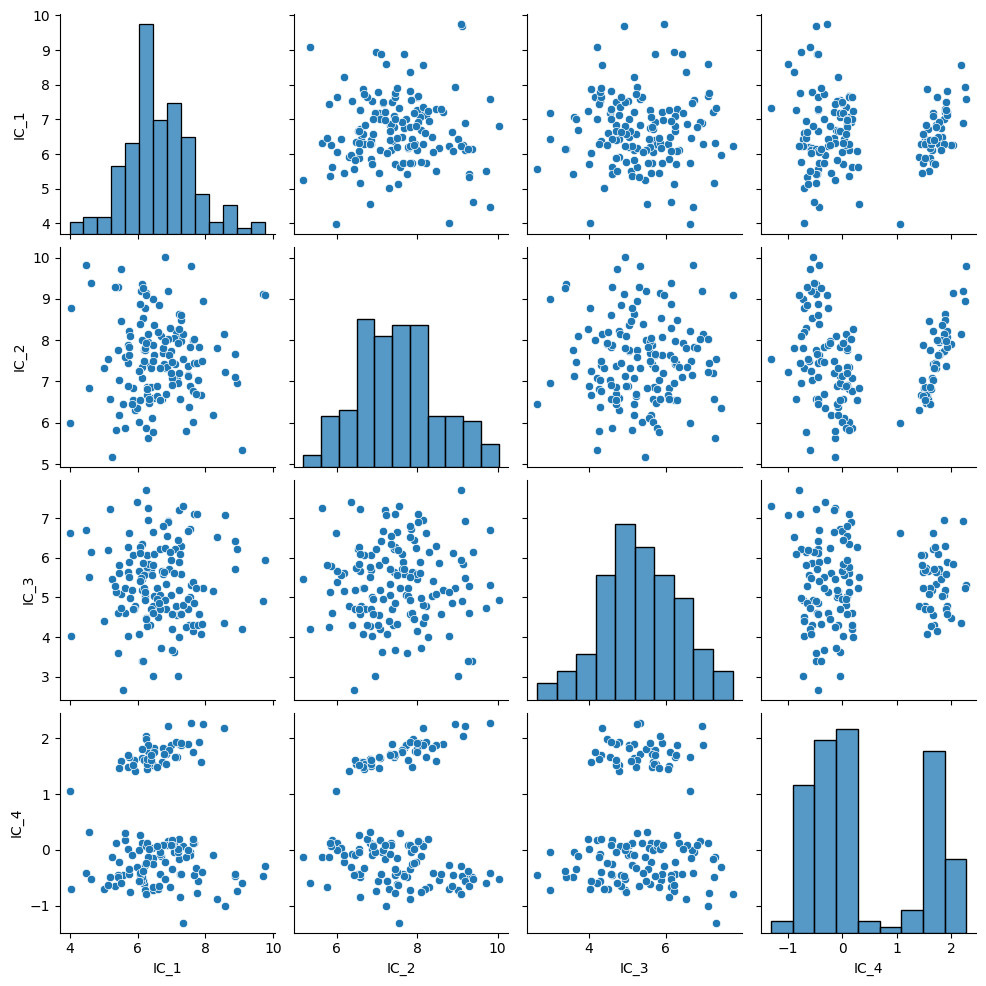

In [6]:
ics.plot()

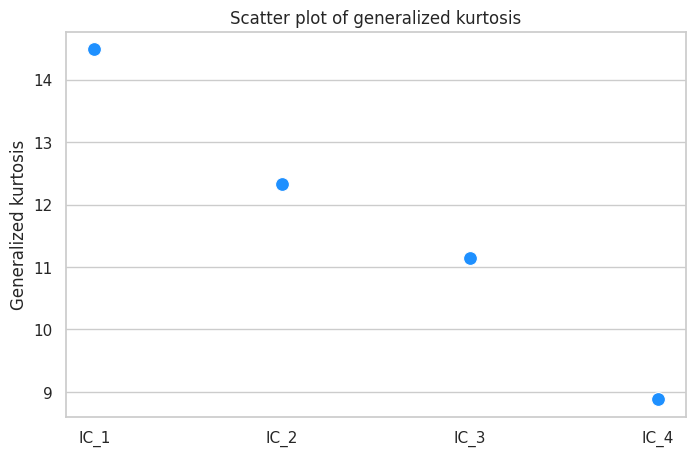

In [7]:
ics.plot_kurtosis()

## Example 2: Add your own scatter matrix (MCD) to ICS

To do so, we will use the [MCD](https://scikit-learn.org/stable/modules/generated/sklearn.covariance.MinCovDet.html) implementation from scikit-learn. This is how it can be computed on the iris dataset:

In [8]:
from sklearn.covariance import MinCovDet
from icspylab import Scatter

mcd_fit = MinCovDet().fit(X)
mcd_loc = mcd_fit.location_
mcd_cov = mcd_fit.covariance_

print("location: ", mcd_loc)
print("scatter: ", mcd_cov)

location:  [5.74328358 3.05074627 3.57462687 1.12985075]
scatter:  [[ 0.5646937  -0.06801738  1.08803854  0.45863333]
 [-0.06801738  0.18623079 -0.3834139  -0.14166407]
 [ 1.08803854 -0.3834139   2.84995322  1.21262308]
 [ 0.45863333 -0.14166407  1.21262308  0.54209401]]


The scatter parameters of ICS (`S1` and `S2`) must be functions returning a `Scatter` object. `Scatters` have 3 attributes: location, scatter and label.

Let's create a function for MCD that we will use as `S1`:

In [9]:
def mcd_scatter(X, **kwargs):
  mcd_fit = MinCovDet(**kwargs).fit(X)
  mcd_loc = mcd_fit.location_
  mcd_cov = mcd_fit.covariance_

  return Scatter(location=mcd_loc, scatter=mcd_cov, label="MCD")

mcd_scatter(X)

In [10]:
ics2 = ICS(S1=mcd_scatter, S2=cov)

# Fit and transform the ICS model (equivalent of the function ICS-S3() from the R package ICS)
ics2.fit_transform(X)

# Printing a summary
ics2.describe()


ICS based on two scatter matrices
S1: mcd_scatter
S1_args: {}
S2: cov
S2_args: {}

Information on the algorithm:
algorithm: whiten
center: False
fix_signs: scores

The generalized kurtosis measures of the components are:
IC_1: 1.9743
IC_2: 1.1292
IC_3: 1.0304
IC_4: 0.9634

The coefficient matrix of the linear transformation is:
     sepal length (cm) sepal width (cm) petal length (cm) petal width (cm)
IC_1       -0.62189      2.26102      3.39524     -6.32509
IC_2        1.88907      0.03203     -1.63673      2.86534
IC_3        1.82001     -2.91551     -0.74552     -0.30737
IC_4        1.89915     -0.45901     -1.11096     -0.25522


You can pass different parameters for `MinCovDet()` (see the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.covariance.MinCovDet.html) for more details). They can be specified in `ICS()` with the `S1_args` parameter.

In [11]:
ics2 = ICS(S1=mcd_scatter, S2=cov, S1_args={"support_fraction": 0.25})

# Fit and transform the ICS model (equivalent of the function ICS-S3() from the R package ICS)
ics2.fit_transform(X)

# Printing a summary
ics2.describe()


ICS based on two scatter matrices
S1: mcd_scatter
S1_args: {'support_fraction': 0.25}
S2: cov
S2_args: {}

Information on the algorithm:
algorithm: whiten
center: False
fix_signs: scores

The generalized kurtosis measures of the components are:
IC_1: 5.6479
IC_2: 1.2882
IC_3: 0.8957
IC_4: 0.7737

The coefficient matrix of the linear transformation is:
     sepal length (cm) sepal width (cm) petal length (cm) petal width (cm)
IC_1        0.59924      1.84103     -1.62493      0.80246
IC_2        0.09444     -2.63954     -1.77600      3.04519
IC_3       -2.84768      1.60693      2.44014     -2.85950
IC_4       -0.95968      1.29472     -0.60158      2.95044


## Example 3: Fitting and transforming separately

Separating `fit` and `transform` is particularly useful in a machine learning framework because it ensures that transformations are learned only from the training data, preventing data leakage and enabling consistent preprocessing during both training and inference.

In [12]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# Load the Iris dataset
iris = load_iris()
X = iris.data
y = iris.target

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a logistic regression model with ICS as a preprocessing step
ics = ICS()
model = LogisticRegression(max_iter=200)

# Train the model on the training set
ics.fit(X_train)
X_train_ics = ics.transform(X_train)
model.fit(X_train_ics, y_train)

# Make predictions on the test set
X_test_ics = ics.transform(X_test)
y_pred = model.predict(X_test_ics)

## Example 4: ICS with simulated data

The function below generates data following a mixture of Gaussian distributions.

In [13]:
import numpy as np

def generate_gaussian_mixture(alpha, n, sigma, mu):
    """
    Generates a Gaussian Mixture Model (GMM) with the given parameters.

    Args:
        alpha (list of float): Proportions of points assigned to each cluster (must sum to 1).
        n (int): Total number of data points to generate.
        sigma (list of np.ndarray): List of covariance matrices (size k).
        mu (list of np.ndarray): List of mean vectors (centroids) for each cluster (size k).

    Returns:
        np.ndarray: Matrix of generated data points (n x d).
        np.ndarray: Array of cluster labels (size n).
    """
    # Validate inputs
    assert np.isclose(sum(alpha), 1.0), "The elements of alpha must sum to 1."
    assert len(alpha) > 0, "Alpha must contain at least one group proportion."
    assert len(alpha) == len(sigma), "Alpha and sigma must have the same length."
    assert len(alpha) == len(mu), "Alpha and mu must have the same length."

    # Number of clusters k, and Dimensionality of the data d
    k = len(alpha)
    d = mu[0].shape[0]

    # Determine the number of points for each group based on alpha
    points_per_group = (np.array(alpha) * n).astype(int)
    # Adjust to ensure the total points add up to n
    points_per_group[0] = n - np.sum(points_per_group[1:])

    # Generate data
    data = []
    labels = []
    for i in range(k):
        # Generate points from a multivariate normal distribution
        group_points = np.random.default_rng().multivariate_normal(mu[i], sigma[i], points_per_group[i])
        data.append(group_points)  # Append generated points for this cluster
        labels.extend([i] * points_per_group[i])  # Assign the same label to all points in this cluster

    # Combine data points into a single array (n x d)
    data = np.vstack(data)
    # Convert labels into a numpy array
    labels = np.array(labels)

    return data, labels

In [53]:
# Group proportions
alpha = [0.2, 0.1, 0.7]

# Group centers
mu = [np.array([1, 6, 4, 0, 0, 0]), # group 1
      np.array([20, 0, 9, 0, 0, 0]), # group 2
      np.array([9, -11, -3, 0, 0, 0])] # group 3

# Group covariances
sigma = [np.eye(6) for _ in range(3)] # Identity matrix for each group

n = 1000

data, labels = generate_gaussian_mixture(alpha, n, sigma, mu)

Run ICS.

In [54]:
ics3 = ICS(S1=cov, S2=cov4)
scores = ics3.fit_transform(data)

Plot the resulting coordinates.

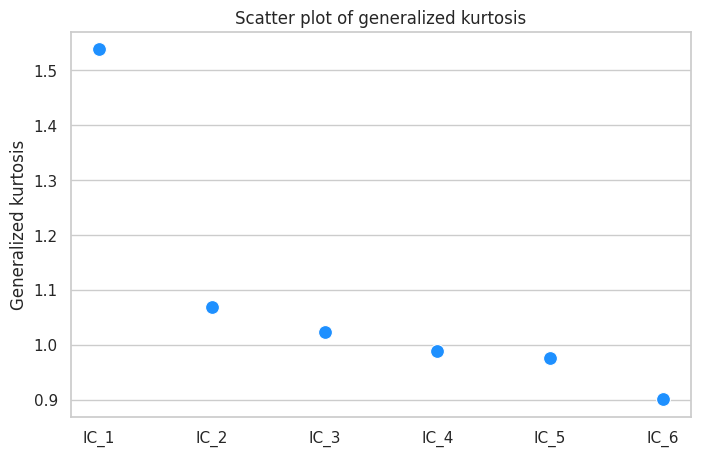

In [55]:
ics3.plot_kurtosis()

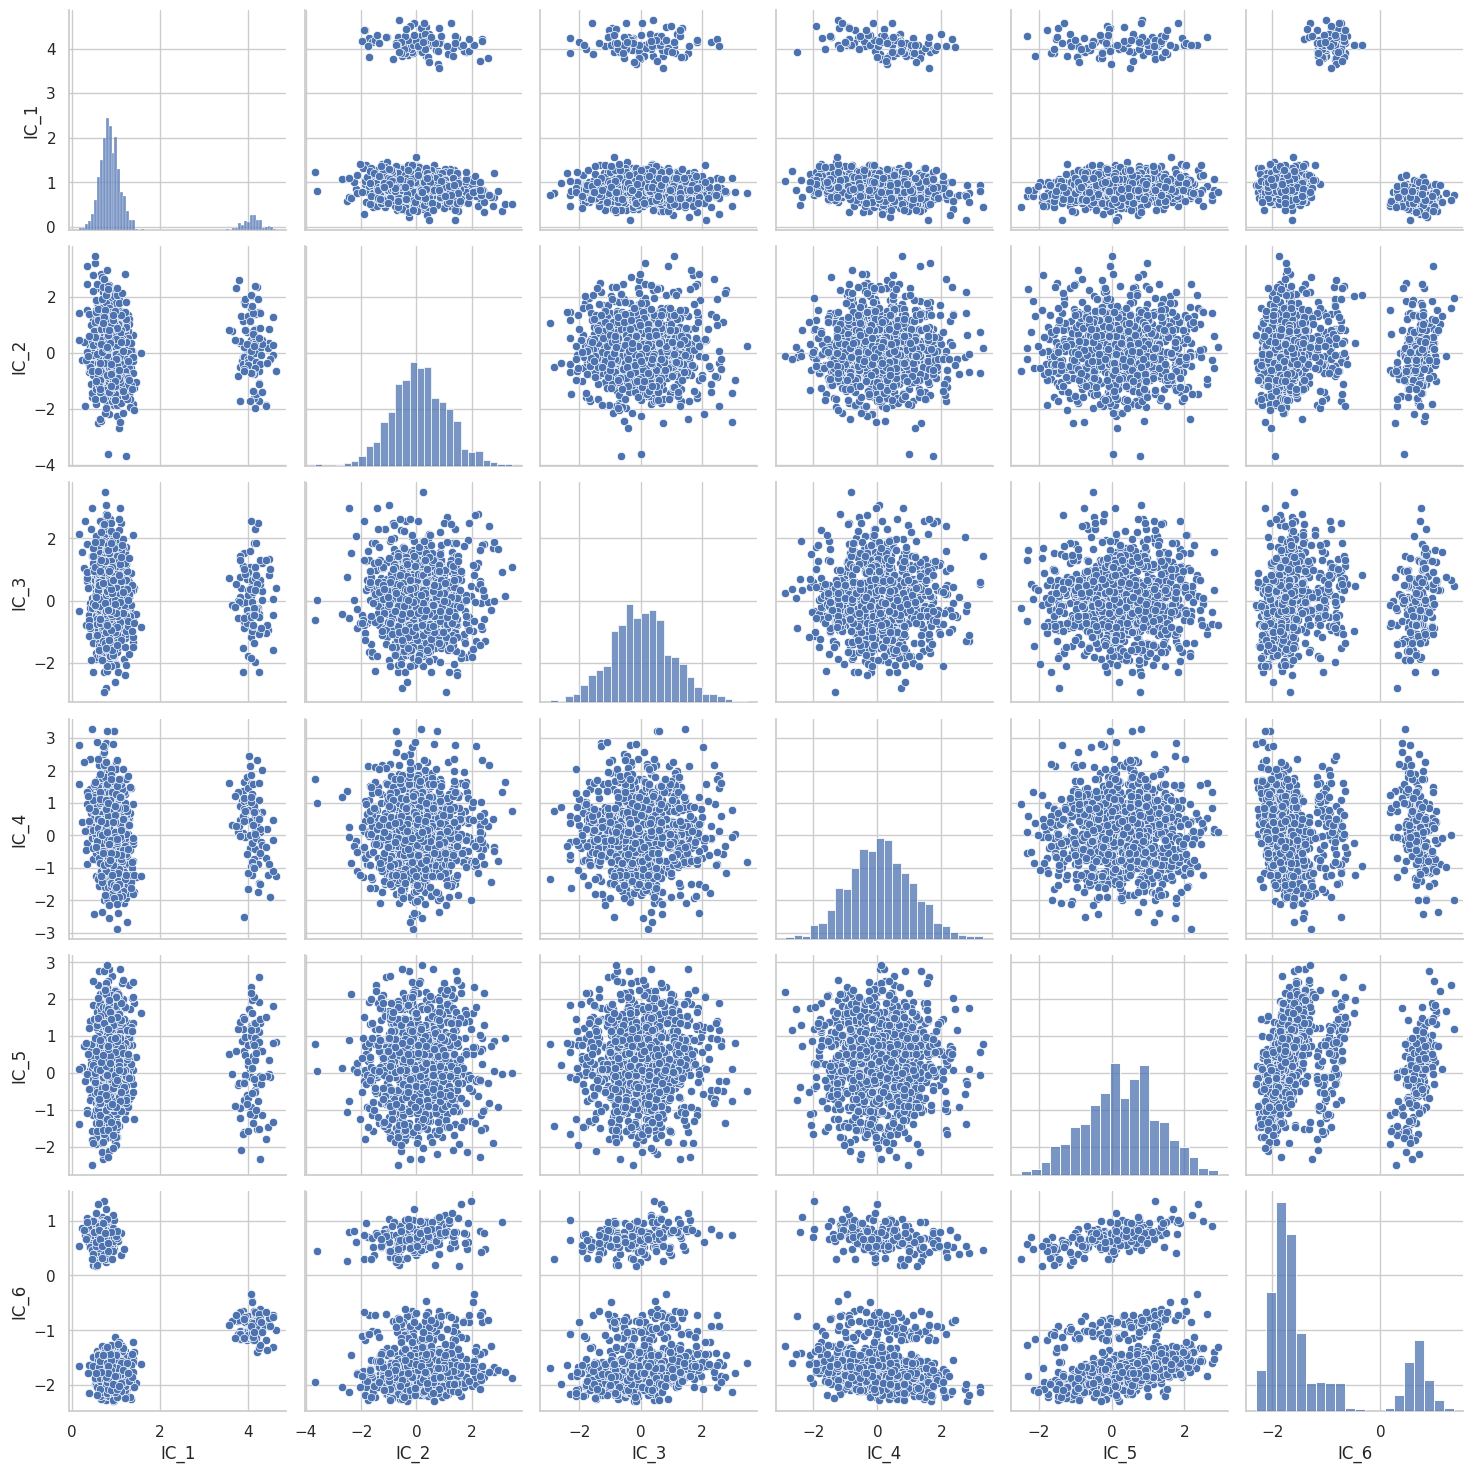

In [56]:
ics3.plot()